# Timelag Sandbox
Play around with creating a new object for dealing with cubes of AIA data and computing timelags from them with Dask

In [1]:
import sys
import dask.bytes
import dask.array as da
import dask.dataframe as df
import dask
import distributed
from dask import delayed, compute
from astropy.io import fits
from astropy.time import Time
import astropy.units as u
from astropy.io.fits.hdu.base import BITPIX2DTYPE
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import sunpy.map
from sunpy.util.metadata import MetaDict
from astropy.coordinates import SkyCoord
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from sunpy.physics.differential_rotation import diffrot_map
#from header_helpers import validate_dtype_shape
from sunpy.instr.aia import aiaprep
#from synthesizAR.instruments import InstrumentSDOAIA

sys.path.append('../scripts/')
from aiacube import DistributedAIACube

Define the instrument 

In [2]:
#aia = InstrumentSDOAIA([0,1]*u.s,None)

Define some functions for constructing a Dask array from a bunch of FITS files

In [ ]:
class DelayedFITS:
    def __init__(self, file, shape, dtype, hdu=0):
        self.shape = shape
        self.dtype = dtype
        self.file = file
        self.hdu = hdu
    
    def __getitem__(self, item):
        with self.file as fi:
            with fits.open(fi) as hdul:
                return hdul[self.hdu].section[item]

In [ ]:
def validate_dtype_shape(head):
    naxes = head['NAXIS']
    dtype = BITPIX2DTYPE[head['BITPIX']]
    shape = [head[f'NAXIS{n}'] for n in range(naxes, 0, -1)]
    #date_obs = head['DATE-OBS']
    return dtype, shape

In [ ]:
def get_header(fn, hdu=0):
    with fn as fi:
        return MetaDict(sunpy.io.fits.get_header(fi)[hdu])

In [3]:
def correlation_2d(stacked, timelags, channel_a, channel_b):
    """
    Create Dask task graph to compute cross-correlation using FFT for each pixel in an AIA map
    """
    darray_a = stacked[channel_a][::-1]
    darray_b = stacked[channel_b]
    # Normalize
    std_a = darray_a.std(axis=0)
    std_a = dask.array.where(std_a == 0, 1, std_a)
    v_a = (darray_a - darray_a.mean(axis=0)[np.newaxis]) / std_a[np.newaxis]
    std_b = darray_b.std(axis=0)
    std_b = dask.array.where(std_b == 0, 1, std_b)
    v_b = (darray_b - darray_b.mean(axis=0)[np.newaxis]) / std_b[np.newaxis]
    # Fast Fourier Transform of both channels
    fft_a = dask.array.fft.rfft(v_a, axis=0, n=timelags.shape[0])
    fft_b = dask.array.fft.rfft(v_b, axis=0, n=timelags.shape[0])
    # Inverse of product of FFTS to get cross-correlation (by convolution theorem)
    return dask.array.fft.irfft(fft_a * fft_b, axis=0, n=timelags.shape[0])

In [ ]:
class DistributedAIACube(object):
    """
    Load sequences of AIA images over multiple channels and operate on them
    in a distributed and parallelized way.
    """
    def __init__(self, read_template, channels=None):
        client = distributed.get_client()
        self.channels = ['94','131','171','193','211','335'] if channels is None else channels
        # Open files with Dask
        templates = {c: read_template.format(c) for c in self.channels}
        openfiles = {c: dask.bytes.open_files(temp) for c,temp in templates.items()}
        # Get headers from all FITS files
        self.headers = self._get_headers(openfiles)
        # Get dtype and shape
        self.dtype,self.shape = self._get_dtype_and_shape()
        # Construct maps
        self.maps = self._get_maps(openfiles)
        
    def _get_maps(self,openfiles,):
        arrays = {c: [da.from_array(DelayedFITS(f,shape=self.shape,dtype=self.dtype,hdu=0),chunks=self.shape) 
                      for f in files] 
                  for c,files in openfiles.items()}
        maps = {}
        for c in arrays.keys():
            maps[c] = [delayed(sunpy.map.sources.AIAMap)(a, h) for a,h in zip(arrays[c], self.headers[c])]
        return maps
        
    def _get_headers(self, openfiles):
        futures = {c: client.map(get_header, fn) for c,fn in openfiles.items()}
        return {c: client.gather(fut) for c,fut in futures.items()}
    
    def _get_dtype_and_shape(self,):
        dtypes = {c: [validate_dtype_shape(h) for h in head] for c, head in self.headers.items()}
        if not all([d == list(dtypes.values())[0] for d in dtypes.values()]):
            raise ValueError('All maps must have same shape and dtype')
        return list(dtypes.values())[0][0]
    
    @property
    def time(self,):
        """
        Note that this should really check for date-obs and then do something different if that exists
        """
        return u.Quantity([h['t_obs'] for h in self.headers[self.channels[0]]], 
                          self.headers[self.channels[0]][0]['tunit'])
    
    @property
    def unstacked_data(self,):
        return {c: [da.from_delayed(m.data, dtype=self.dtype, shape=self.shape) for m in maps] for c,maps in self.maps.items()}
    
    @property
    def stacked_data(self,):
        return {c: da.stack(array) for c,array in self.unstacked_data.items()}
        
    def rechunk(self,shape):
        return {c: d.rechunk(shape) for c,d in self.stacked_data.items()}

Spin up the Dask cluster

In [4]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1,)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33644 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


Construct the Dask array

In [5]:
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA/{}/map_t*.fits'

In [6]:
distaia = DistributedAIACube(read_template)

In [ ]:
read_templates = {wav: read_template.format(wav=wav) for wav in [c['name'] for c in aia.channels]}

In [ ]:
filebytes = {wav: dask.bytes.open_files(temp,) for wav, temp in read_templates.items()}

In [ ]:
futures = {wav: client.map(get_header, fnames) for wav, fnames in filebytes.items()}
headers = {wav: client.gather(fut) for wav, fut in futures.items()}

In [ ]:
dtypes = {wav: [validate_dtype_shape(h) for h in head] for wav, head in headers.items()}
dtypes
assert all([d == list(dtypes.values())[0] for d in dtypes.values()])
dtype, shape = list(dtypes.values())[0][0]

In [ ]:
arrs = {wav: [da.from_array(DelayedFITS(fn, shape=shape, dtype=dtype, hdu=0), chunks=shape)
         for fn in files] for wav, files in filebytes.items()}

In [ ]:
maps = {}
for wav in arrs.keys():
    maps[wav] = [delayed(sunpy.map.sources.AIAMap)(arr, header) for arr, header in zip(arrs[wav], headers[wav])]

In [ ]:
time = u.Quantity([h['t_obs'] for h in headers['94']], headers['94'][0]['tunit'])

In [ ]:
rarrs = {wav: [da.from_delayed(m.data, dtype=np.float64, shape=shape) for m in mps] for wav, mps in maps.items()}

In [ ]:
stacked = {wav: da.stack(arrs) for wav, arrs in rarrs.items()}

In [ ]:
stacked = {wav: d.rechunk(time.shape+(shape[0]//10,shape[1]//10)) for wav, d in stacked.items()}

Now, compute the timelag and correlation maps for each channel pair

In [9]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [10]:
timelags = u.Quantity(np.hstack([-np.diff(distaia.time).value.cumsum()[::-1], [0],
                                 np.diff(distaia.time).value.cumsum()]),distaia.time.unit)

In [11]:
bounds = (-6*u.hour,6*u.hour)
bindices, = np.where(np.logical_and(timelags >= bounds[0], timelags <= bounds[1]))
i_start = bindices[0]
i_stop = bindices[-1] + 1

In [12]:
correlation_maps = {}
timelag_maps = {}
for ca,cb in channel_pairs[:1]:
    cor = correlation_2d(distaia.rechunk(distaia.time.shape + (distaia.shape[0]//10,distaia.shape[1]//10)),
                         timelags,f'{ca}',f'{cb}')
    # Timelag
    i_timelag = cor[i_start:i_stop,:,:].argmax(axis=0).compute()
    timelag = timelags[i_start:i_stop][i_timelag]
    meta = distaia.headers['94'][0].copy()
    del meta['instrume']
    del meta['t_obs']
    del meta['wavelnth']
    meta['bunit'] = 's'
    meta['comment'] = f'{ca}-{cb} timelag'
    plot_settings = {'cmap': 'RdBu_r', 'vmin': timelags[i_start:i_stop].value.min(),
                     'vmax': timelags[i_start:i_stop].value.max()}
    timelag_maps[f'{ca}-{cb}'] = sunpy.map.GenericMap(timelag,meta,plot_settings=plot_settings)
    # Max correlation
    max_cor = cor[i_start:i_stop,:,:].max(axis=0).compute()
    meta['bunit'] = ''
    meta['comment'] = f'{ca}-{cb} cross-correlation'
    plot_settings['cmap'] = 'plasma'
    del plot_settings['vmin']
    del plot_settings['vmax']
    correlation_maps[f'{ca}-{cb}'] = sunpy.map.GenericMap(max_cor,meta,
                                                          plot_settings=plot_settings)
    

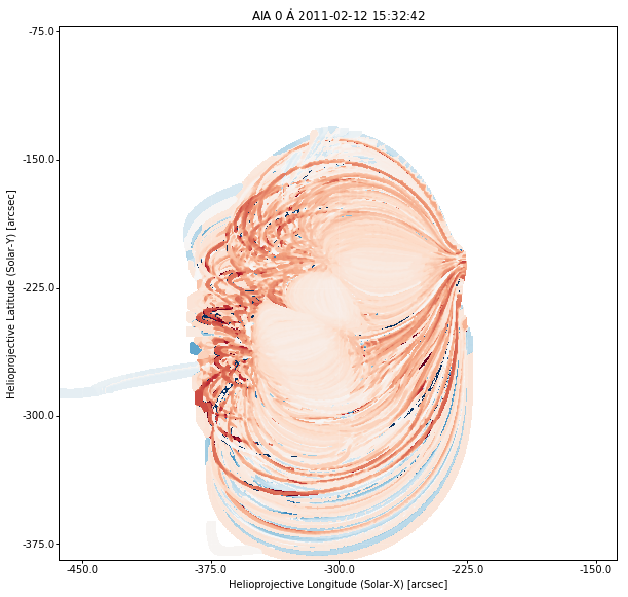

In [14]:
plt.figure(figsize=(10,10))
m_cor = correlation_maps['94-335']
m_tl = timelag_maps['94-335']
data_tl = np.where(m_cor.data >= 500., m_tl.data, np.nan)
m_tl = sunpy.map.GenericMap(data_tl,m_tl.meta,plot_settings=m_tl.plot_settings)
m_tl.plot(vmin=-(1*u.hour).to(u.s).value,vmax=(1*u.hour).to(u.s).value)
plt.show()

In [17]:
stack_rechunk = distaia.rechunk(distaia.time.shape + (distaia.shape[0]//10,distaia.shape[1]//10))
ts94 = stack_rechunk['94'][:,250,250]
ts335 = stack_rechunk['335'][:,250,250]

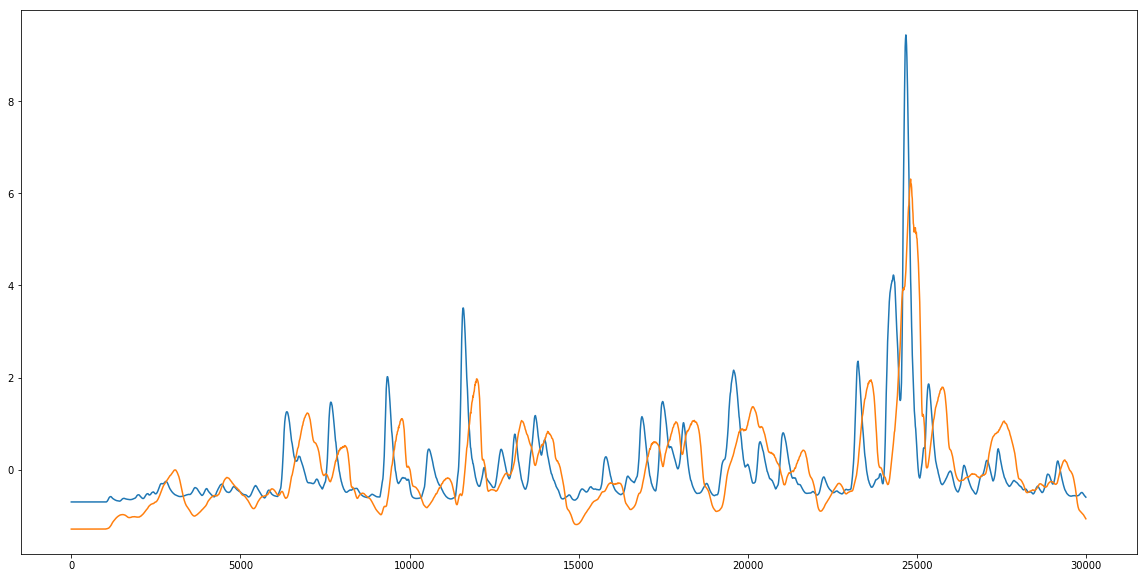

In [18]:
plt.figure(figsize=(20,10))
plt.plot(distaia.time,(ts94 - ts94.mean())/ts94.std(),label='94')
plt.plot(distaia.time,(ts335 - ts335.mean())/ts335.std(),label='335')
#plt.ylim(0,40)

In [ ]:
np.float